In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd

In [21]:
# to test whether pymc3 can be used we test it on a non-linear SDE
# that has an analytical solution Cox,Ingersol, Ross Econometrica 53,385-407(1985)
# dX = alpha(beta-X)dt + sigma*sqrt(X)dW
# model parameters:
alpha = 0.2
beta = 0.08
sigma = 0.03
dt = 1/12000 # 1000th of a year
N = 10000
t = np.arange(N+1)*dt

In [22]:
dW = np.random.normal(loc=0,scale=np.sqrt(2*dt),size=N)
X = [0.1]
for i,onedW in enumerate(dW):
    n = X[i] + alpha*(beta-X[i])*dt + sigma*np.sqrt(X[i])*onedW
    X.append(n)
X = np.array(X)

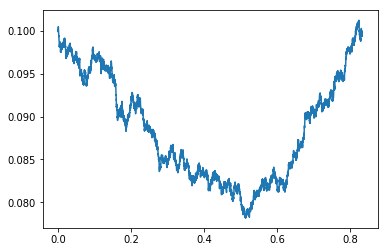

In [23]:
plt.plot(t,X)